In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.stats import pearsonr
from mplsoccer.pitch import Pitch
from sklearn.metrics import roc_auc_score
import os
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

C:\Users\Juhaninho\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
plt.style.use('fivethirtyeight')
params = {'axes.titlesize': 'x-large',
          'axes.labelsize': 'large', 
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
plt.rcParams.update(params)

In [3]:
shots = pd.read_excel('extracted_data/shots.xlsx')

In [4]:
shots.head()

,duration,match_id,minute,second,under_pressure,pass_height,assistant_id,location_x,location_y,team_id,player_id,goalkeeper_id,goal,statsbomb_xg,first_touch,follows_dribble,foot_shot,header,open_goal,defender,midfielder,striker,goal_distance,regular_play,from_corner,from_free_kick,from_throw_in,from_counter,from_goal_kick,from_keeper,from_kick_off,backheel,diving_header,half_volley,lob,overhead_kick,volley,corner,free_kick,open_play,penalty,kick_off,goal_angle,num_teammates,num_opposition,gk_in_goal
0,1.586764,9592,2,10,0,1,5211,106.0,57.8,217,5503,6792,0,0.026399,0,0,1,0,0,0,0,1,22.645971,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,12.703542,0,1,1
1,2.356000,9592,18,34,0,1,-1,90.0,29.1,217,5246,6792,0,0.025043,0,0,1,0,0,0,0,1,31.918803,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,13.459294,1,4,1
2,0.480919,9592,25,9,1,1,5470,110.0,39.5,217,5503,6792,1,0.484256,0,0,1,0,0,0,0,1,10.012492,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,43.517792,0,1,1
3,0.392120,9592,29,31,0,1,-1,96.0,21.1,217,5246,6792,0,0.046703,0,0,1,0,0,0,0,1,30.548486,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,11.823033,0,4,1
4,0.512047,9592,30,13,0,1,5503,106.0,39.6,217,5470,6792,0,0.334151,0,0,1,0,0,0,1,0,14.005713,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,31.867962,0,1,1


In [5]:
shots.shape

(12003, 46)

In [6]:
len(shots['match_id'].unique())

485

In [7]:
X = shots[['under_pressure', 'pass_height', 'first_touch', 'follows_dribble', 'foot_shot', 'header', 'open_goal', 'defender',
           'midfielder', 'striker', 'goal_distance', 'regular_play', 'from_corner', 'from_free_kick', 'from_throw_in', 
           'from_counter', 'from_goal_kick', 'from_keeper', 'from_kick_off', 'backheel', 'diving_header', 'half_volley', 
           'lob', 'overhead_kick', 'volley', 'corner', 'free_kick', 'open_play', 'penalty', 'goal_angle', 
           'num_teammates', 'num_opposition', 'gk_in_goal']]
y = shots['goal']

Relevanzanalyse

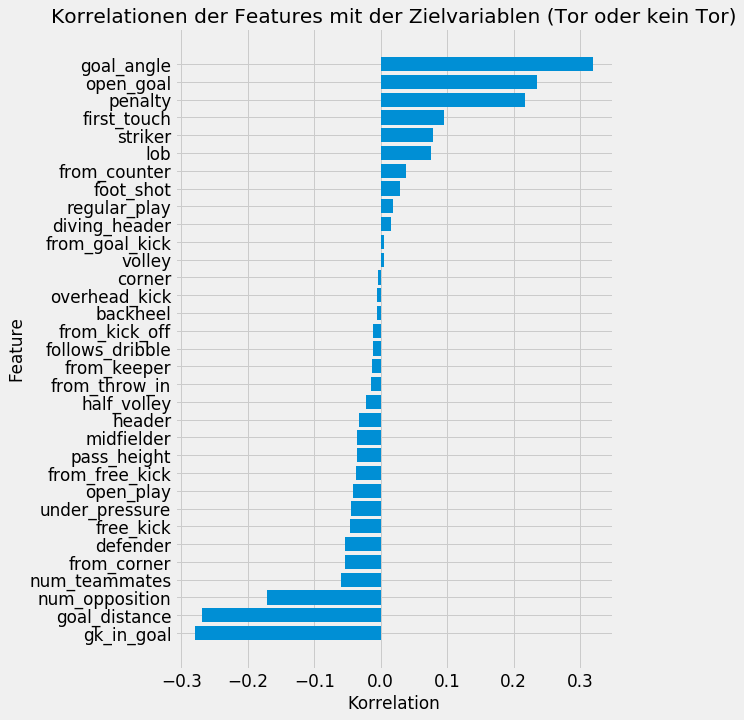

In [9]:
plt.style.use('fivethirtyeight')
corrs = dict([[col, pearsonr(shots['goal'], shots[col])[0]] for col in X.columns])
corrs = dict(sorted(corrs.items(), key=lambda item: item[1]))
plt.figure(figsize=(7,11))
plt.barh(y=list(corrs.keys()), width=list(corrs.values()))
plt.title('Korrelationen der Features mit der Zielvariablen (Tor oder kein Tor)')
plt.ylabel('Feature')
plt.xlabel('Korrelation')
plt.show()

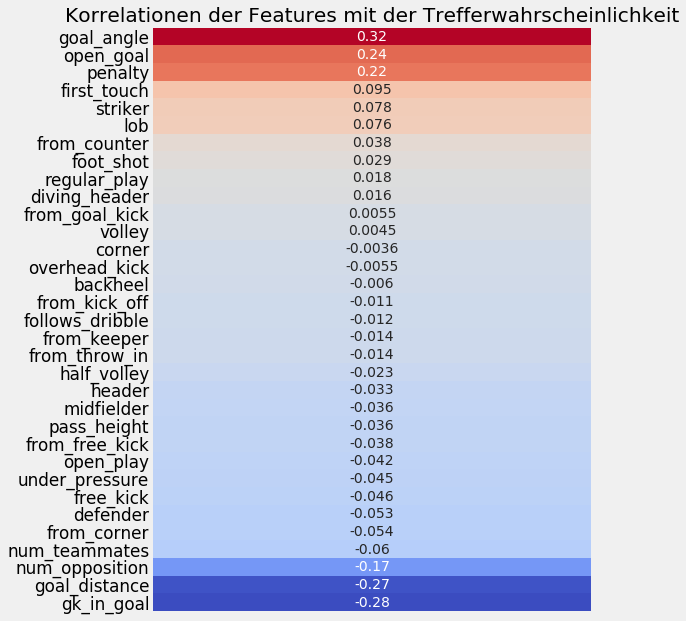

In [10]:
corrs = dict([[col, pearsonr(shots['goal'], shots[col])[0]] for col in X.columns])
corrs = dict(sorted(corrs.items(), key=lambda item: item[1], reverse=True))
df_corrs = pd.DataFrame()
df_corrs['feature'] = list(corrs.keys())
df_corrs['correlation'] = list(corrs.values())
plt.figure(figsize=(7,10))
sns.heatmap(df_corrs[['correlation']], yticklabels=df_corrs['feature'], xticklabels='',
            cmap='coolwarm', annot=True, cbar=False)
plt.title('Korrelationen der Features mit der Trefferwahrscheinlichkeit')
plt.show()

In [11]:
len(X.columns)

33

In [12]:
# add all features that are correlated to the target variable
initial_features = X.columns.tolist()
relevant_features = []
for feature in initial_features:
    corr, p_value = pearsonr(shots[feature], shots['goal'])
    if p_value <= 0.05:
        relevant_features.append(feature)

In [13]:
print(relevant_features)

['under_pressure', 'pass_height', 'first_touch', 'foot_shot', 'header', 'open_goal', 'defender', 'midfielder', 'striker', 'goal_distance', 'from_corner', 'from_free_kick', 'from_counter', 'half_volley', 'lob', 'free_kick', 'open_play', 'penalty', 'goal_angle', 'num_teammates', 'num_opposition', 'gk_in_goal']


In [14]:
set(X.columns) - set(relevant_features)

{'backheel',
 'corner',
 'diving_header',
 'follows_dribble',
 'from_goal_kick',
 'from_keeper',
 'from_kick_off',
 'from_throw_in',
 'overhead_kick',
 'regular_play',
 'volley'}

In [15]:
len(relevant_features)

22

In [16]:
X = X[relevant_features]

Redundanzanalyse

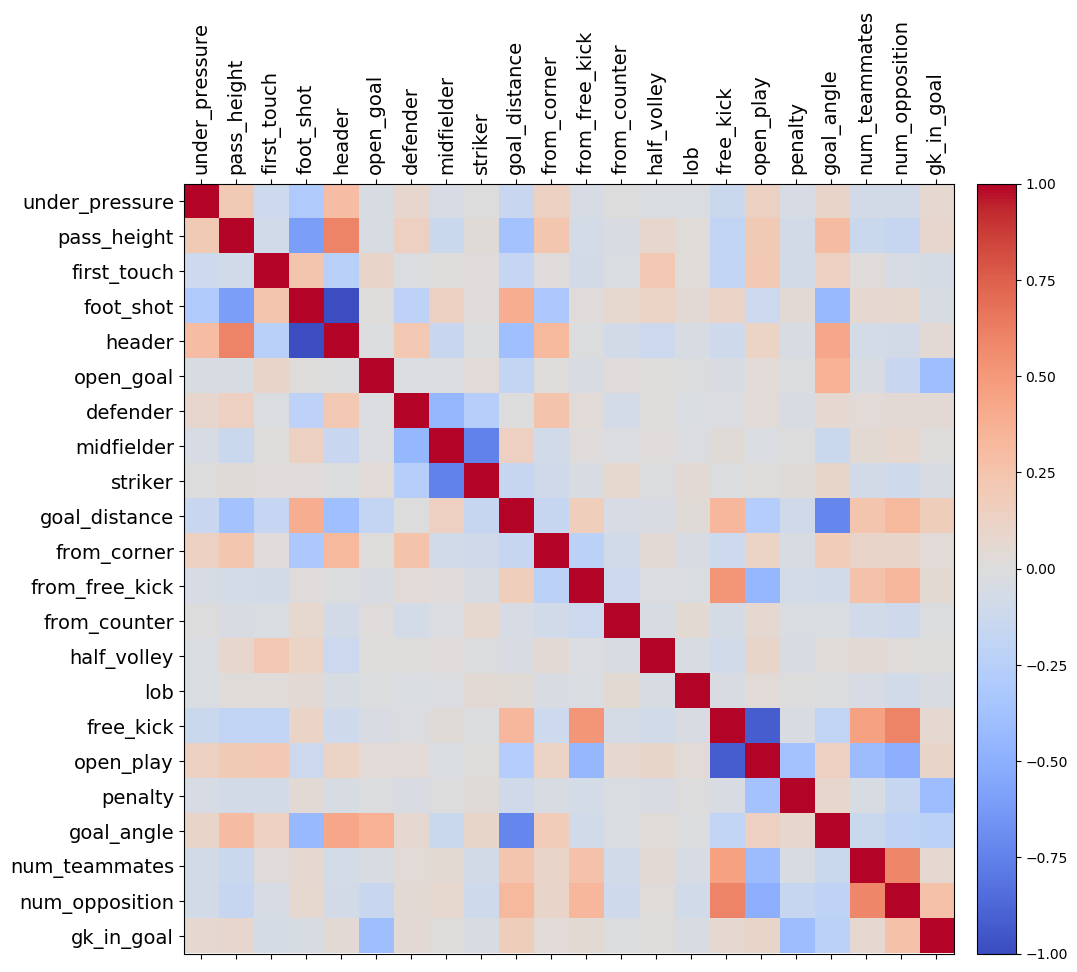

In [25]:
plt.style.use('default')
corr = X.corr()
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax, pad=0.015)
ticks = np.arange(0, len(X.columns), 1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(X.columns, fontsize=14)
ax.set_yticklabels(X.columns, fontsize=14)
plt.show()

In [26]:
# remove one feature if it is correlated to another feature
redundant_features = []
for i in range(len(relevant_features)):
    for j in range(i+1, len(relevant_features)):
        corr, p_value = pearsonr(shots[relevant_features[i]], shots[relevant_features[j]])
        if (np.abs(corr) >= 0.72) & (p_value <= 0.05):
            corr_i, _ = pearsonr(shots[relevant_features[i]], shots['goal'])
            corr_j, _ = pearsonr(shots[relevant_features[j]], shots['goal'])
            if np.abs(corr_i) <= np.abs(corr_j):
                redundant_features.append(relevant_features[i])
            else:
                redundant_features.append(relevant_features[j])
            break
selected_features = list(set(relevant_features) - set(redundant_features))

In [27]:
redundant_features

['foot_shot', 'midfielder', 'open_play']

In [28]:
print(selected_features)

['under_pressure', 'half_volley', 'pass_height', 'from_free_kick', 'goal_distance', 'defender', 'from_counter', 'from_corner', 'striker', 'first_touch', 'gk_in_goal', 'open_goal', 'free_kick', 'goal_angle', 'num_teammates', 'lob', 'num_opposition', 'header', 'penalty']


In [34]:
selected_features = ['goal_distance', 'goal_angle', 'pass_height', 'defender', 'striker', 'half_volley', 'lob', 'header', 
                     'first_touch', 'penalty', 'free_kick', 'from_free_kick', 'from_corner', 'from_counter',  
                     'under_pressure', 'open_goal', 'gk_in_goal', 'num_teammates', 'num_opposition']

In [35]:
len(selected_features)

19

In [37]:
X = X[selected_features]

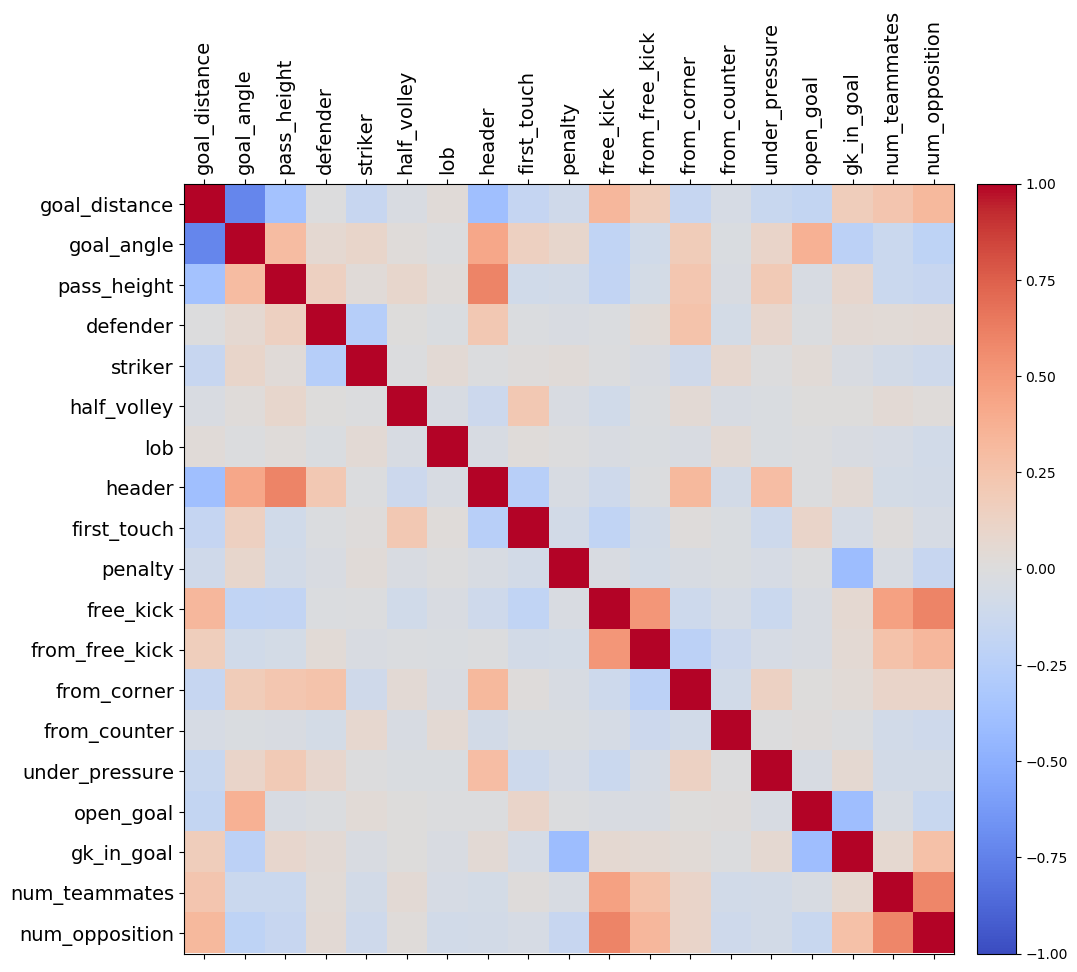

In [38]:
plt.style.use('default')
corr = X.corr()
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax, pad=0.015)
ticks = np.arange(0, len(X.columns), 1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(X.columns, fontsize=14)
ax.set_yticklabels(X.columns, fontsize=14)
plt.show()

Erstellung des Modells

In [25]:
# Train-Test-Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [26]:
# Erstellung des Modells mit Hyperparameter-Optimierung
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

log_reg_params = [{'C': [0.1, 1, 10]}]
log_reg_grid_search = GridSearchCV(LogisticRegression(penalty='l2', max_iter=1000, random_state=8), log_reg_params, scoring='roc_auc')
_ = log_reg_grid_search.fit(X_train, y_train)

d_tree_params = {'max_depth': [4, 6, 8], 'max_features': [2, 4, 6]}
d_tree_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=8), d_tree_params, scoring='roc_auc')
_ = d_tree_grid_search.fit(X_train, y_train)

r_forest_params = {'max_depth': [5, 6, 7, 8], 'max_features': [6, 7, 8], 'n_estimators': [50, 100]}
r_forest_grid_search = GridSearchCV(RandomForestClassifier(random_state=8), r_forest_params, scoring='roc_auc')
_ = r_forest_grid_search.fit(X_train, y_train)

g_boosting_params = {'max_depth': [4, 5, 6], 'max_features': [2, 3, 4], 'n_estimators': [50, 100]}
g_boosting_grid_search = GridSearchCV(GradientBoostingClassifier(learning_rate=0.1, random_state=8), g_boosting_params, scoring='roc_auc')
_ = g_boosting_grid_search.fit(X_train, y_train)

In [27]:
clf_names = ['Logistische Regression', 'Entscheidungsbaum', 'Random Forest', 'Gradient Boosting']
grid_searches = [log_reg_grid_search, d_tree_grid_search, r_forest_grid_search, g_boosting_grid_search]
print('Beste Parameter')
for clf_name, grid_search in zip(clf_names, grid_searches):
    print(clf_name + ': ' + str(grid_search.best_params_))

Beste Parameter
Logistische Regression: {'C': 1}
Entscheidungsbaum: {'max_depth': 8, 'max_features': 6}
Random Forest: {'max_depth': 7, 'max_features': 6, 'n_estimators': 100}
Gradient Boosting: {'max_depth': 4, 'max_features': 3, 'n_estimators': 50}


In [28]:
print('Beste Resultate (Trainingssatz)')
for clf_name, grid_search in zip(clf_names, grid_searches):
    print(clf_name + ': ' + str(round(grid_search.best_score_, 3)))

Beste Resultate (Trainingssatz)
Logistische Regression: 0.803
Entscheidungsbaum: 0.769
Random Forest: 0.803
Gradient Boosting: 0.804


In [29]:
print('Beste Resultate (Testsatz)')
for clf_name, grid_search in zip(clf_names, grid_searches):
    print(clf_name + ': ' + str(round(roc_auc_score(y_test, grid_search.best_estimator_.predict_proba(X_test)[:, 1]), 3)))

Beste Resultate (Testsatz)
Logistische Regression: 0.793
Entscheidungsbaum: 0.775
Random Forest: 0.796
Gradient Boosting: 0.801


In [30]:
roc_auc_score(shots['goal'], shots['statsbomb_xg'])

0.8252732128991821

In [31]:
model = g_boosting_grid_search.best_estimator_

In [32]:
# Ensemble Model
log_reg = log_reg_grid_search.best_estimator_
r_forest = r_forest_grid_search.best_estimator_
g_boosting = g_boosting_grid_search.best_estimator_

def predict_proba(X_values):
    preds = [np.mean([log_reg.predict_proba(X_values.iloc[[i]])[0][1], r_forest.predict_proba(X_values.iloc[[i]])[0][1], g_boosting.predict_proba(X_values.iloc[[i]])[0][1]]) for i in range(len(X_values))]
    return preds

roc_auc_score(y_test, predict_proba(X_test))

0.7996096943891641

In [33]:
from sklearn.tree import DecisionTreeClassifier
important_features = ['goal_angle', 'open_goal', 'penalty', 'num_opposition', 'goal_distance', 'gk_in_goal']
d_tree = DecisionTreeClassifier(max_depth=6, max_features=4, random_state=8)
d_tree.fit(X_train[important_features], y_train)
roc_auc_score(y_test, d_tree.predict_proba(X_test[important_features])[:, 1])

0.7648979497385107

C:\Users\Juhaninho\Anaconda3\lib\site-packages\sklearn\tree\_export.py:186: FutureWarning: 'rotate' has no effect and is deprecated in 0.23. It will be removed in 1.0 (renaming of 0.25).
  FutureWarning)


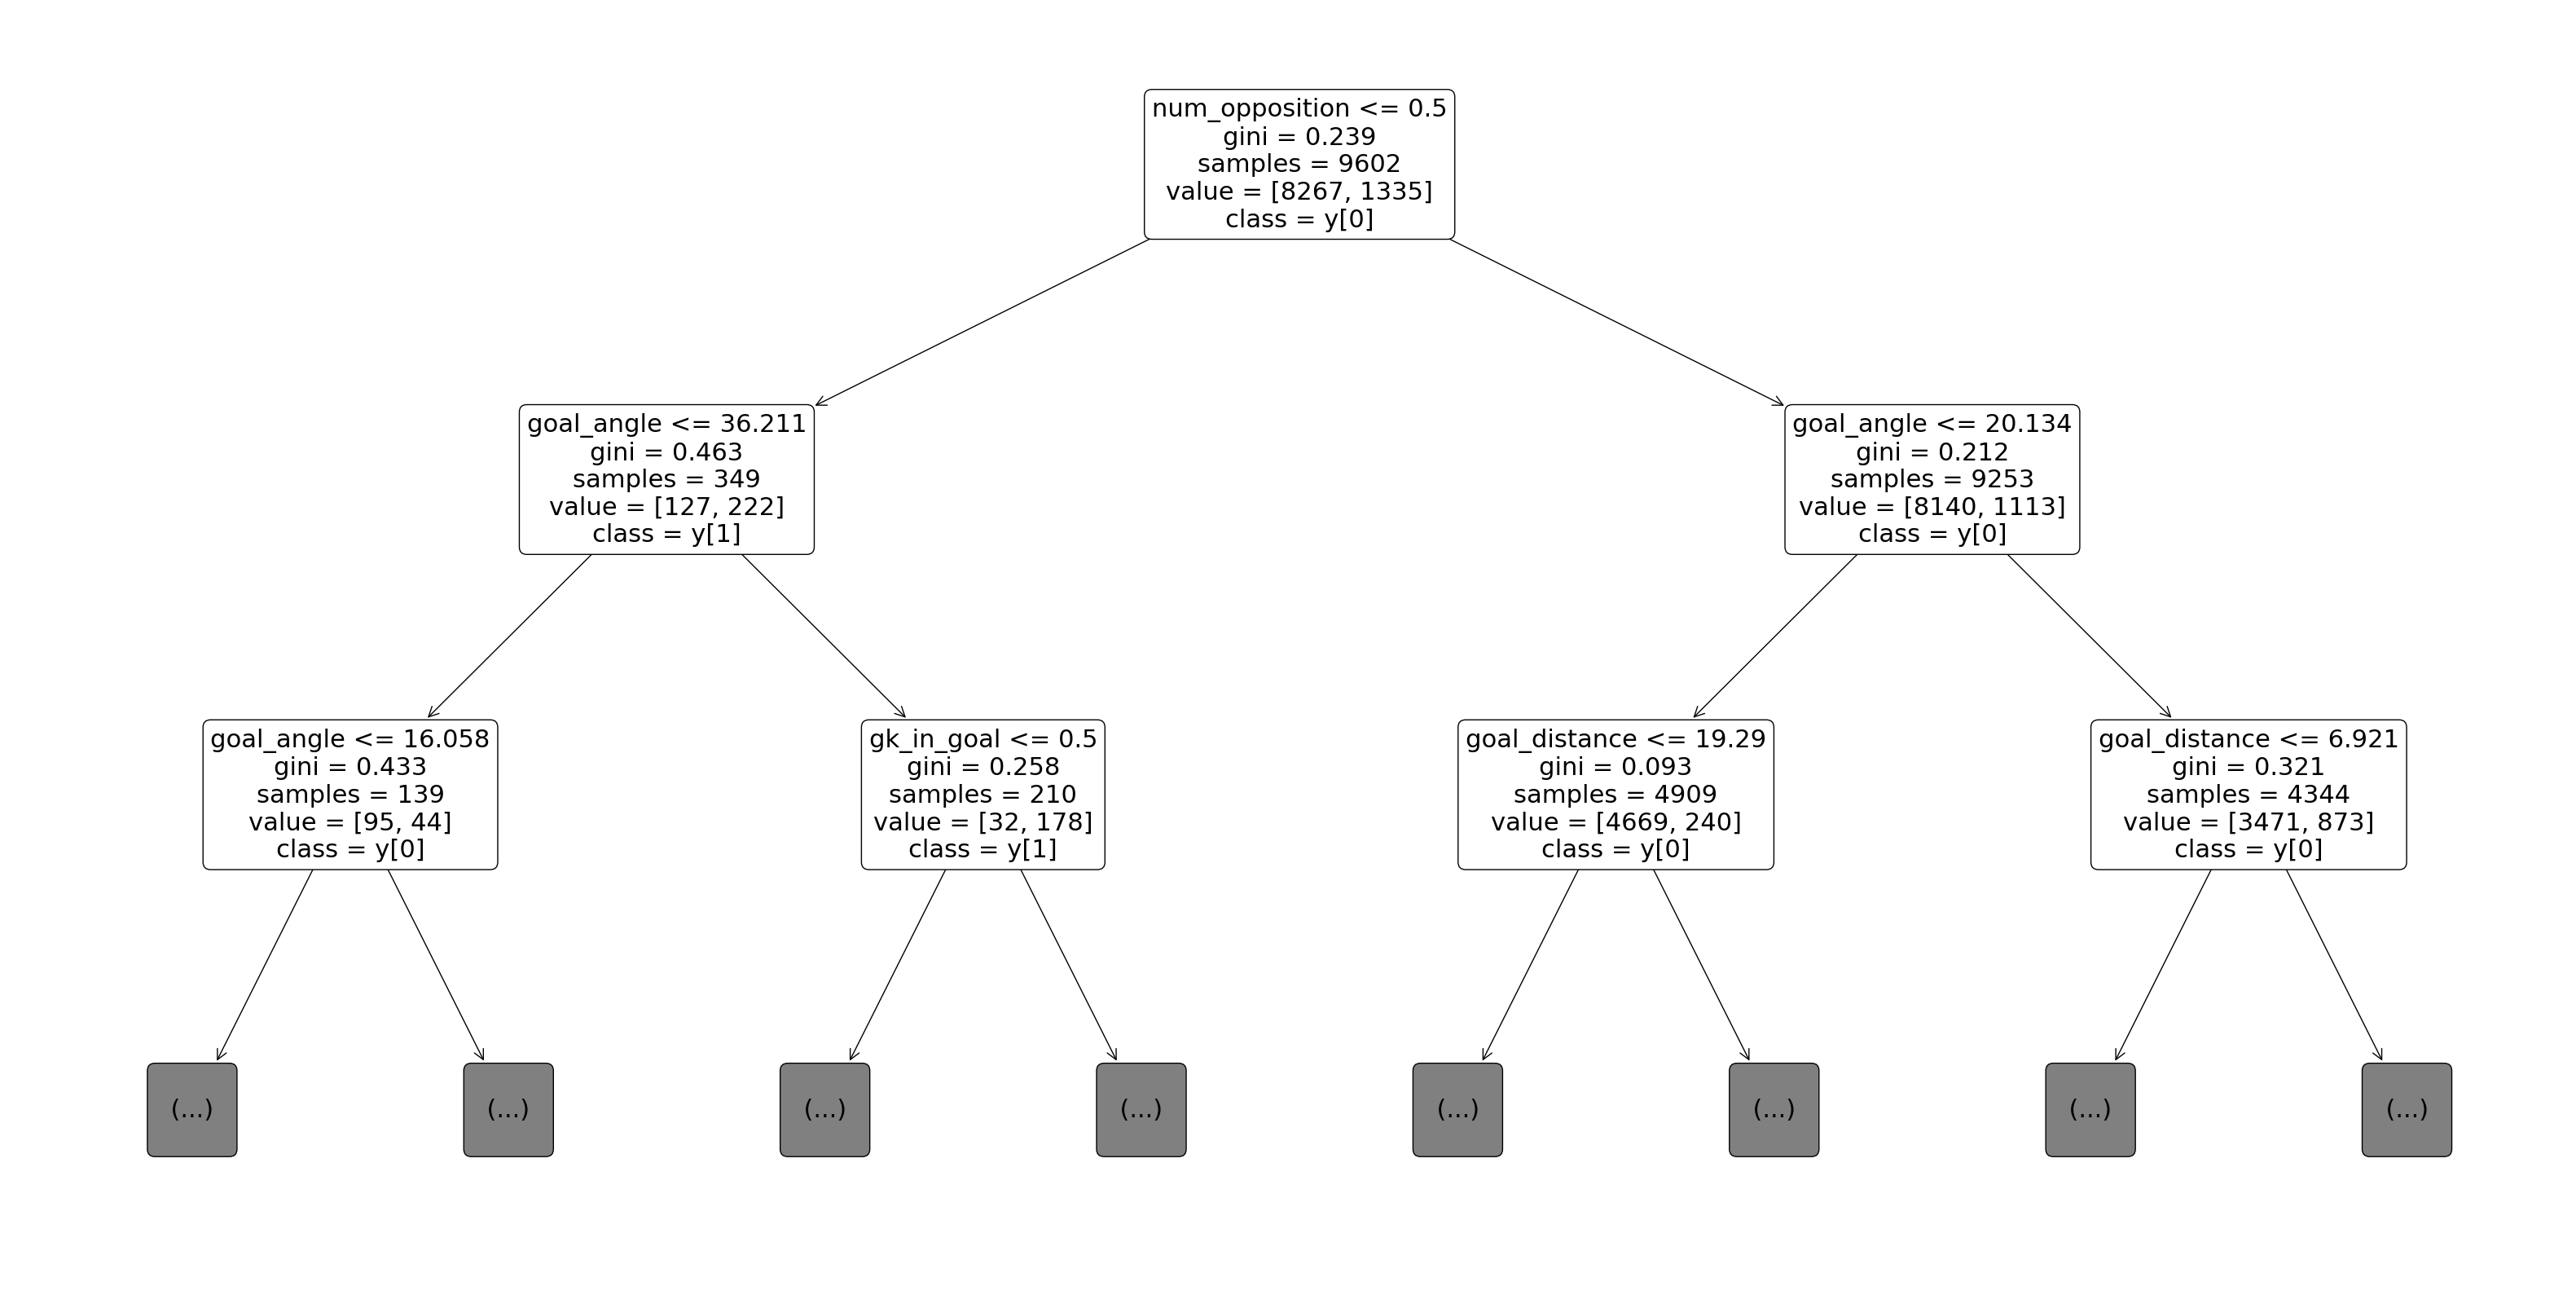

In [34]:
from sklearn.tree import plot_tree
plt.figure(figsize=(40,20))
_ = plot_tree(d_tree, feature_names = important_features, class_names=True, rounded=True, rotate=True, max_depth=2)
plt.show()

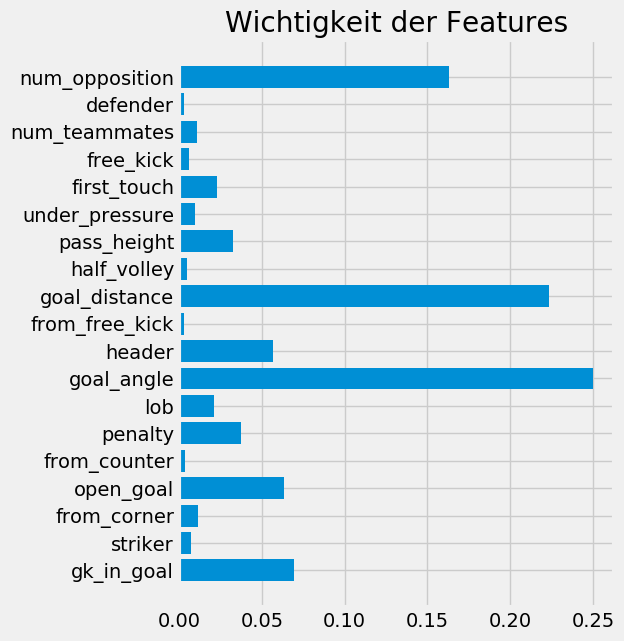

In [35]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(5,7))
plt.barh(y=selected_features, width=model.feature_importances_)
plt.title('Wichtigkeit der Features')
plt.show()

Modellanwendung

In [36]:
# Predictions
shots.loc[:, 'pred_xg'] = model.predict_proba(X)[:, 1]

In [37]:
def get_xg_preds(shots):
    shots.loc[:, 'pred_xg'] = model.predict_proba(shots[selected_features])[:, 1]
    return shots

In [38]:
# Save Model
import joblib
_ = joblib.dump(model, 'models/expected_goals_model.pkl')

In [39]:
# Save Predictions
shots.to_excel('extracted_data/shots_pred.xlsx', index=False)

In [40]:
# Save selected_features
import pickle
with open("models/xg_selected_features.txt", "wb") as fp:
    pickle.dump(selected_features, fp)

Modellevaluierung

In [42]:
pearsonr(shots['statsbomb_xg'], shots['pred_xg'])

(0.9005583616298889, 0.0)

In [43]:
pearsonr(shots['goal'], shots['pred_xg'])

(0.5025386015254021, 0.0)

In [44]:
pearsonr(shots['goal'], shots['statsbomb_xg'])

(0.49006665323716797, 0.0)

In [45]:
shots['statsbomb_xg'].sum()

1499.7747221117002

In [46]:
shots['pred_xg'].sum()

1679.730026407763

In [47]:
shots['goal'].sum()

1645

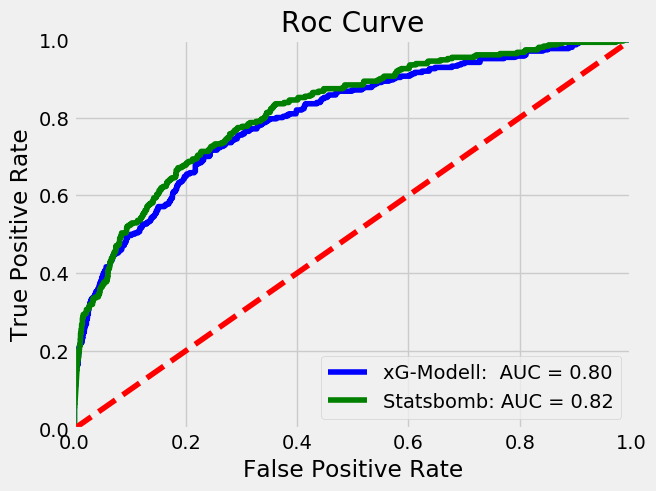

In [48]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'xG-Modell:  AUC = %0.2f' % roc_auc)
fpr, tpr, threshold = roc_curve(y_test, shots.loc[y_test.index, 'statsbomb_xg'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'g', label = 'Statsbomb: AUC = %0.2f' % roc_auc)
plt.title('Roc Curve')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

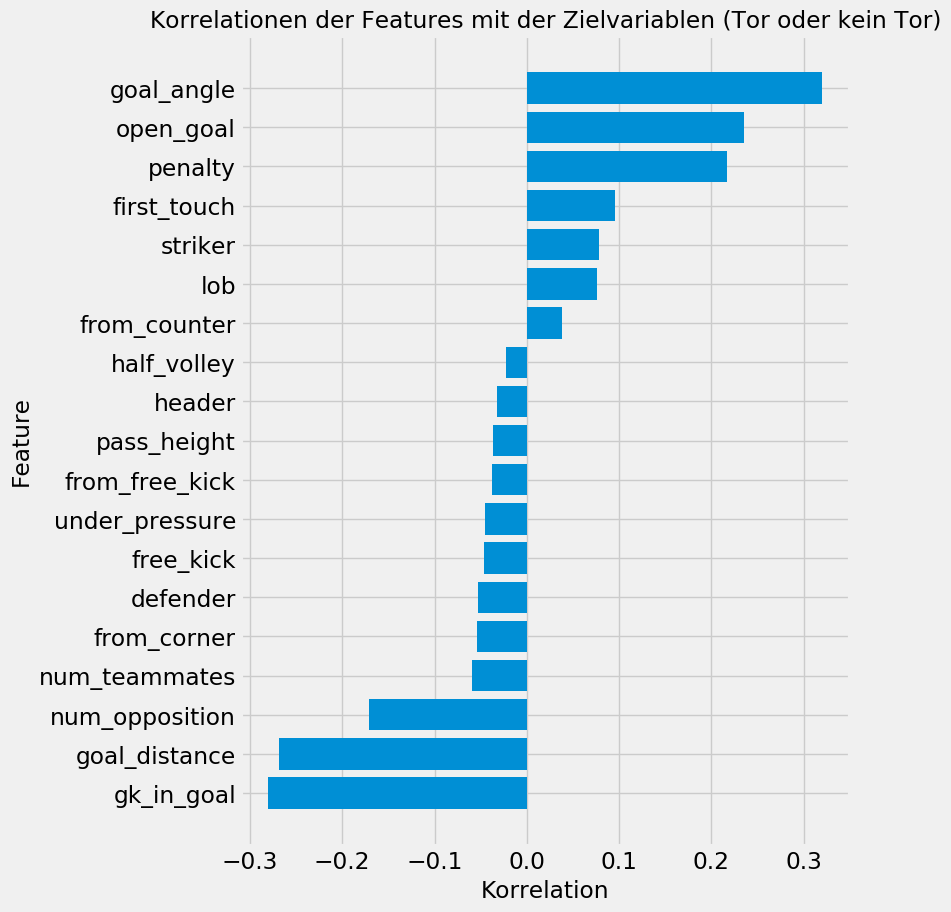

In [50]:
plt.style.use('fivethirtyeight')
params = {'axes.titlesize': 'large', 'axes.labelsize': 'large',  'xtick.labelsize':'large', 'ytick.labelsize':'large'}
plt.rcParams.update(params)
corrs = dict([[col, pearsonr(shots['goal'], shots[col])[0]] for col in X.columns])
corrs = dict(sorted(corrs.items(), key=lambda item: item[1]))
plt.figure(figsize=(7,10))
plt.barh(y=list(corrs.keys()), width=list(corrs.values()))
plt.title('Korrelationen der Features mit der Zielvariablen (Tor oder kein Tor)')
plt.ylabel('Feature')
plt.xlabel('Korrelation')
plt.show()

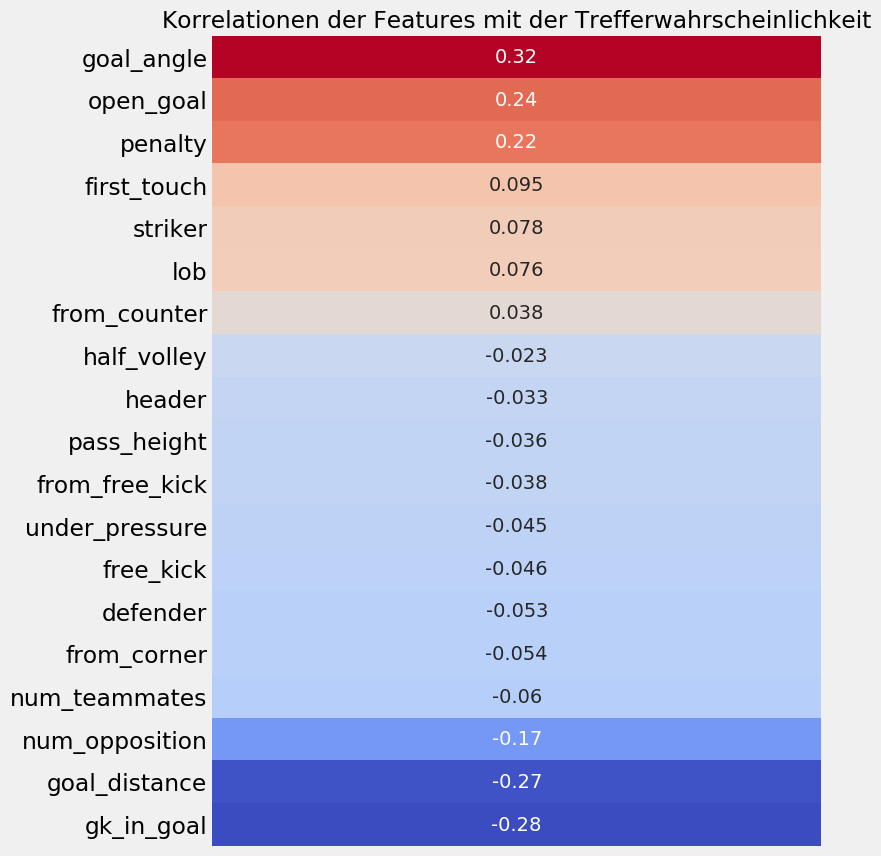

In [51]:
corrs = dict([[col, pearsonr(shots['goal'], shots[col])[0]] for col in X.columns])
corrs = dict(sorted(corrs.items(), key=lambda item: item[1], reverse=True))
df_corrs = pd.DataFrame()
df_corrs['feature'] = list(corrs.keys())
df_corrs['correlation'] = list(corrs.values())
plt.figure(figsize=(7,10))
sns.heatmap(df_corrs[['correlation']], yticklabels=df_corrs['feature'], xticklabels='',
            cmap='coolwarm', annot=True, cbar=False)
plt.title('Korrelationen der Features mit der Trefferwahrscheinlichkeit')
plt.show()

In [52]:
# perform factor analysis
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer()
fa.analyze(X, 6, rotation='varimax')
fa.loadings

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6
gk_in_goal,0.103439,0.057240,0.905270,0.034299,-0.038307,0.009388
striker,-0.048803,0.079833,-0.036143,-0.020256,-0.428110,0.017471
from_corner,0.183723,0.321827,0.013641,0.053098,0.319066,-0.401839
open_goal,-0.001909,0.103120,-0.412191,0.192794,-0.060459,0.042630
from_counter,-0.113992,-0.042494,0.002565,-0.033099,-0.177036,-0.067686
penalty,-0.080011,-0.050688,-0.388416,-0.130720,-0.033064,-0.045224
lob,-0.085275,-0.033406,-0.008389,-0.020005,-0.049617,-0.002015
goal_angle,0.010260,0.702793,-0.375350,0.322175,-0.148117,0.010687
header,0.023196,0.826160,0.039451,-0.330693,0.202468,-0.037326
from_free_kick,0.321360,-0.048670,0.040410,-0.073293,0.106399,0.729131


In [54]:
fa.get_factor_variance()

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6
SS Loadings,1.778935,2.336144,1.422026,0.912632,0.755390,0.861241
Proportion Var,0.093628,0.122955,0.074843,0.048033,0.039757,0.045328
Cumulative Var,0.093628,0.216583,0.291427,0.339460,0.379217,0.424546
